# Princpled Bayesian Workflow

Example from https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#5_close_enough_for_an_effective_demonstration with help from code at https://github.com/lstmemery/principled-bayesian-workflow-pymc3

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import theano.tensor as T
import theano
import matplotlib.pyplot as plt
from simulation_based_calibration import *
from tqdm import tqdm
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

# Section 5
## 5.1

In [3]:
n_sensors = 1000
n_samples = 1000
prior_sd = 6.44787

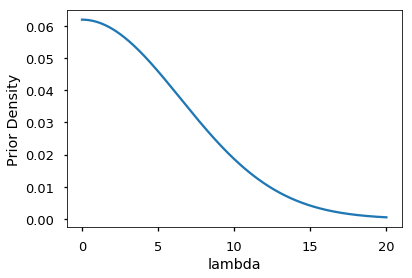

In [4]:
lmda = np.linspace(0, 20, num=int(20/1e-4))
p_lmda = stats.norm(loc=0, scale=prior_sd).pdf(lmda)
plt.plot(lmda, p_lmda)
plt.xlabel("lambda"); plt.ylabel("Prior Density");

In [5]:
# get prior predictive distribution
with pm.Model() as model:
    lmda = pm.HalfNormal("lmda", sd=prior_sd)
    y = pm.Poisson("y", mu=lmda, shape=(n_sensors,), observed=None)
    
with model:
    trace = pm.sample_prior_predictive(n_samples)
    
simulated_lmdas = trace["lmda"]
simulated_ys = trace["y"]

  0%|          | 0/50 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
100%|██████████| 50/50 [00:00<00:00, 71.36it/s]


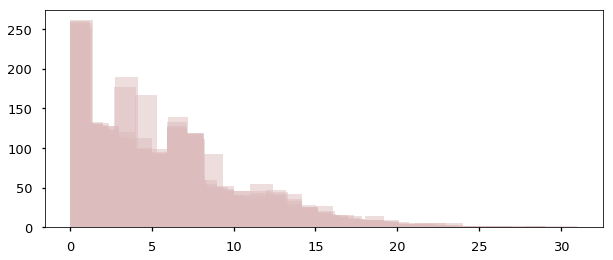

In [6]:
plt.subplots(figsize=(10,4))
for i in tqdm(range(50)):
    sns.distplot(simulated_ys[i,:], hist=True, kde=False, color=c_light,
                hist_kws={'alpha':0.5})

In [9]:
# Run simulation-based calibration
def test_model(y=None):
    with pm.Model() as model:
        lmda = pm.HalfNormal("lmda", sd=prior_sd)
        y = pm.Poisson("y", mu=lmda, shape=(n_sensors,),observed=y)
    return model

sbc = SBC(test_model, 'y', num_simulations=100, 
          sample_kwargs={'draws':25, 'tune':50})

In [10]:
sbc.run_simulations()

100%|██████████| 100/100 [02:31<00:00,  1.74s/it, WarningType.BAD_ACCEPTANCE=69]


(<Figure size 864x576 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c27982e48>,
       dtype=object))

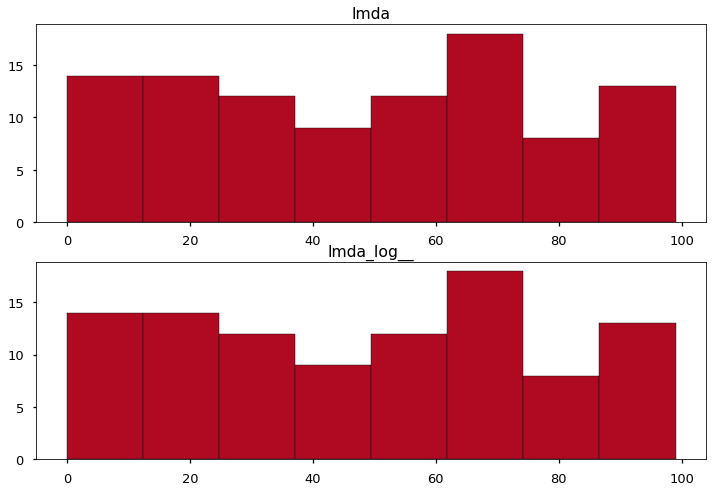

In [11]:
sbc.plot_sbc()

In [15]:
# posterior sensitivities analysis.
s = pm.stats.summary(trace, varnames=['lmda'])
z_

lmda    5.01287
Name: mean, dtype: float64